In [3]:
import pandas as pd

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
import joblib
import xlsxwriter
import os

In [7]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.express as px

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score

In [53]:
# @changes from inna
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [8]:
def load_data_old(folderPathTrain, folderPathTest):
    print('load old files')
    df_categorical = pd.read_excel(f'{folderPathTrain}/TRAIN_CATEGORICAL_METADATA.xlsx')
    df_matrices = pd.read_csv(f'{folderPathTrain}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
    df_quant = pd.read_excel(f'{folderPathTrain}/TRAIN_QUANTITATIVE_METADATA.xlsx')
    df_solutions = pd.read_excel(f'{folderPathTrain}/TRAINING_SOLUTIONS.xlsx')  
    print('load test files')
    df_categorical_test = pd.read_excel(f'{folderPathTest}/TEST_CATEGORICAL.xlsx')
    df_matrices_test = pd.read_csv(f'{folderPathTest}/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
    df_quant_test = pd.read_excel(f'{folderPathTest}/TEST_QUANTITATIVE_METADATA.xlsx')
    return df_categorical,df_matrices,df_quant,df_solutions,df_categorical_test,df_matrices_test,df_quant_test

In [9]:
def load_data_new(folderPathTrain, folderPathTest):
    print('load new files')
    df_categorical = pd.read_excel(f'{folderPathTrain}/TRAIN_CATEGORICAL_METADATA_new.xlsx')
    df_matrices = pd.read_csv(f'{folderPathTrain}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
    df_quant = pd.read_excel(f'{folderPathTrain}/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
    df_solutions = pd.read_excel(f'{folderPathTrain}/TRAINING_SOLUTIONS.xlsx')  
    print('load test files')
    df_categorical_test = pd.read_excel(f'{folderPathTest}/TEST_CATEGORICAL.xlsx')
    df_matrices_test = pd.read_csv(f'{folderPathTest}/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
    df_quant_test = pd.read_excel(f'{folderPathTest}/TEST_QUANTITATIVE_METADATA.xlsx')
    return df_categorical,df_matrices,df_quant,df_solutions,df_categorical_test,df_matrices_test,df_quant_test

In [10]:
def join_data(categorical,matrices,quantitative,solutions=None):
    print('joining data frames')
    cat_quant = pd.merge(categorical, quantitative , on ='participant_id', how ='inner')
    cat_quant_mat = pd.merge(cat_quant, matrices , on ='participant_id', how ='inner')
    if isinstance(solutions, pd.DataFrame):
        cat_quant_mat_sols = pd.merge(cat_quant_mat, solutions , on ='participant_id', how ='inner')
        return cat_quant_mat_sols
    else:    
        return cat_quant_mat

In [82]:
def save_model(model,name,accuracy,y_test,y_pred):
    joblib.dump({'model': model, 'y_test': y_test,'y_pred': y_pred, 'accuracy': accuracy}, name)
    print('saved the model')

def save_exploration(model,name):
    joblib.dump({'model': model}, name)
    print('save_exploration')

def get_model(name):
    model = joblib.load(name)
    print('get_model')
    return model

In [12]:
def loaddata_joinframes_splittestandtrain(df_categorical_new,df_matrices_new,df_quant_new,df_solutions_new):
    joined_training_data = join_data(df_categorical_new,df_matrices_new,df_quant_new,df_solutions_new)
    X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
    Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
    X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)
    return X_train_data, X_test_data, y_train_data, y_test_data

### Reference for parts of below sections taken from datathon slides
### https://colab.research.google.com/drive/1texL3JnRdTHyevP3_GzousIFKjTj0LmY#scrollTo=IGFYIQSmlUMb

In [13]:
def xgboost_classifer():
    print('xgboost_classifer')
    # Initialize the base classifier
    classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)
    multioutput_classifier = MultiOutputClassifier(classifier)
    return multioutput_classifier

In [14]:
def train(model,X_train, y_train):
    print('train the model')
    X_train  = X_train_data.drop(columns = ['participant_id'] )
    y_train  = y_train_data.drop(columns = ['participant_id'] )
    model.fit(X_train, y_train)

In [15]:
def predict(model,X_test):
    print('predict with the model')
    X_test_data  = X_test.drop(columns = ['participant_id'] )
    y_pred = model.predict(X_test_data)
    predictions_df = pd.DataFrame(
        y_pred,
        columns=['Predicted_Gender', 'Predicted_ADHD']
    )
    return predictions_df

In [16]:
def calculate_score(y_test,y_pred):
    print('calculate score with prediction vs true values')
    y_test_results  = y_test.drop(columns = ['participant_id'] )
    accuracy = accuracy_score(y_test_results, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

In [17]:
def split_data(X,Y):
    print('split the train and test data')
    X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train_data, X_test_data, y_train_data, y_test_data

In [18]:
def multi_output_accuracy(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Compute accuracy for each target variable and return the mean
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

In [19]:
def do_cross_validation(X,Y,model):
    # Perform cross-validation on the training data
    X_train_cv  = X.drop(columns = ['participant_id'] )
    y_train_cv  = Y.drop(columns = ['participant_id'] )
    # Create a scorer using scikit-learn's make_scorer
    multi_output_scorer = make_scorer(multi_output_accuracy)
    cv_scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring=multi_output_scorer)
    
    # Output the cross-validation results
    print("Cross-validation scores for each fold:", cv_scores)
    print("Mean CV score:", f'Mean Accuracy: {np.mean(cv_scores) * 100:.2f}%')

## Train with old dataset (only for reference)

In [20]:
folderPathTrain, folderPathTest = 'Datafiles/TRAIN/' , 'Datafiles/TEST/'
df_categorical,df_matrices,df_quant,df_solutions,df_categorical_test,df_matrices_test,df_quant_test = load_data_old(folderPathTrain, folderPathTest)
joined_training_data = join_data(df_categorical,df_matrices,df_quant,df_solutions)

load old files
load test files
joining data frames


In [21]:
joined_training_data.head(2)

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45,...,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984,1,1
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0,...,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381,1,0


In [22]:
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )

In [23]:
X.head(2)

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45,...,-0.037630,-0.072599,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0,...,0.014106,-0.001084,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381


In [24]:
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]

In [25]:
Y.head(2)

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0


In [26]:
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)

split the train and test data


## training with old dataset (only for reference)

In [27]:
classifier = xgboost_classifer()

xgboost_classifer


In [28]:
train(classifier,X_train_data, y_train_data)

train the model


In [29]:
y_pred = predict(classifier,X_test_data)

predict with the model


In [30]:
accuracy = calculate_score(y_test_data,y_pred)

calculate score with prediction vs true values
Accuracy: 56.38%


In [31]:
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)

xgboost_classifer
Cross-validation scores for each fold: [0.81893004 0.78600823 0.69753086 0.66322314 0.32644628]
Mean CV score: Mean Accuracy: 65.84%


In [32]:
save_model(classifier,'old_data_xgb_basic_nochanges',accuracy,y_test_data,y_pred)

saved the model


In [ ]:
#get_model('old_data_xgb_basic_nochanges')

##  ****** training with new dataset ******

## run this step once to load new dataset

In [37]:
folderPathTrain, folderPathTest = 'Datafiles/TRAIN_NEW/' , 'Datafiles/TEST/'
df_categorical_new,df_matrices_new,df_quant_new,df_solutions_new,df_categorical_test,df_matrices_test,df_quant_test = load_data_new(folderPathTrain, folderPathTest)

load new files
load test files


In [38]:
df_matrices_new.head(2)

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176


In [39]:
df_categorical_new.head(2)

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0


In [40]:
df_quant_new.head(2)

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN


In [41]:
df_solutions_new.head(2)

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0


## train raw data with basic xgb classifier and verify accuracy

In [42]:
joined_training_data = join_data(df_categorical_new,df_matrices_new,df_quant_new,df_solutions_new)
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)
classifier = xgboost_classifer()
train(classifier,X_train_data, y_train_data)
y_pred = predict(classifier,X_test_data)
accuracy = calculate_score(y_test_data,y_pred)
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)
save_model(classifier,'new_data_xgb_basic_nochanges',accuracy,y_test_data,y_pred)

joining data frames
split the train and test data
xgboost_classifer
train the model
predict with the model
calculate score with prediction vs true values
Accuracy: 57.20%
xgboost_classifer
Cross-validation scores for each fold: [0.72222222 0.7654321  0.69958848 0.75       0.7107438 ]
Mean CV score: Mean Accuracy: 72.96%
saved the model


In [80]:
X.count()

participant_id                      1213
Basic_Demos_Enroll_Year             1213
Basic_Demos_Study_Site              1213
PreInt_Demos_Fam_Child_Ethnicity    1170
PreInt_Demos_Fam_Child_Race         1159
                                    ... 
196throw_198thcolumn                1213
196throw_199thcolumn                1213
197throw_198thcolumn                1213
197throw_199thcolumn                1213
198throw_199thcolumn                1213
Length: 19928, dtype: int64

## Train with pca data instead of raw connectome matrices data

## question:  shouldnt we use df_matrices_new for this one??

In [75]:
df_matrices_for_pca = df_matrices_new.drop(columns = ['participant_id'] )

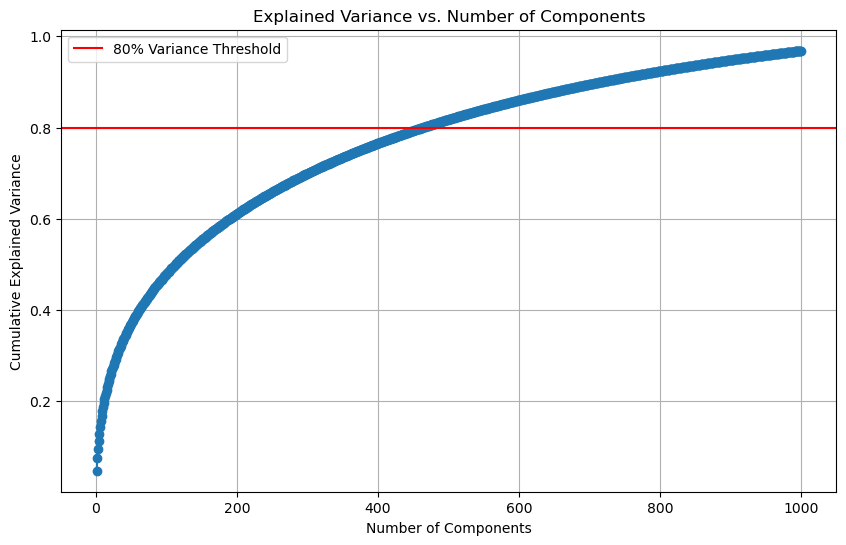

Number of components needed for 80% variance: 464
Original data shape: (1213, 19900)
Reduced data shape: (1213, 464)
save_exploration


In [76]:
# PCA df with index preserved as index

original_index = df_matrices_for_pca.index

# 1. Standardize the data (excluding the first column)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_matrices_for_pca)

# 2. Apply PCA
# Start with a smaller number of components for exploration
pca = PCA(n_components=1000)  # Adjust based on your needs
pca_result = pca.fit_transform(scaled_data)

# 3. Analyze explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# 4. Plot the explained variance to help choose number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='-', label='80% Variance Threshold')
plt.legend()
plt.show()

# 5. Find number of components for desired variance (e.g., 80%)
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components needed for 80% variance: {n_components_80}")

# 6. Re-run PCA with the optimal number of components
pca_final = PCA(n_components=n_components_80)
pca_result_final = pca_final.fit_transform(scaled_data)

# 7. Create a DataFrame with the PCA results
pca_df = pd.DataFrame(
    data=pca_result_final,
    columns=[f'PC{i+1}' for i in range(n_components_80)],
    index=original_index
)

# 8. Add the first column back as index
# pca_df[first_col_name] = first_col_values
# pca_df.set_index(first_col_name, inplace=True)

# 9. Now you can use pca_df for your machine learning models
print(f"Original data shape: {df_matrices_for_pca.shape}")
print(f"Reduced data shape: {pca_df.shape}")
save_exploration(pca_df,'new_data_xgb_pca_exploration_v1')

In [83]:
pca_df_1 = get_model('new_data_xgb_pca_exploration_v1')

get_model


In [86]:
pca_df['participant_id'] = df_matrices_new['participant_id']

In [87]:
pca_df.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464,participant_id
0,35.753597,0.090543,-20.350098,19.088315,-30.805000,2.306746,-0.012355,-16.080110,-6.713649,7.132247,...,-4.579191,0.649576,-5.713151,0.667111,-4.043861,0.333597,-0.826567,-1.235517,3.899206,70z8Q2xdTXM3
1,28.459455,-18.887916,10.232790,1.115161,-7.235638,-14.893705,-5.991652,-3.274423,-18.623438,-12.154650,...,-0.611817,6.689392,-1.611045,-0.527794,-3.005883,1.084139,0.936941,3.831925,0.409489,WHWymJu6zNZi


In [88]:
## pca calculation
## pca results save to joblib  def save_exploration(model,name):
## pca model load >> load it instead of df_matrices_new [participant_id ]

joined_training_data = join_data(df_categorical_new,pca_df,df_quant_new,df_solutions_new)
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)

classifier = xgboost_classifer()
train(classifier,X_train_data, y_train_data)
y_pred = predict(classifier,X_test_data)
accuracy = calculate_score(y_test_data,y_pred)
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)
save_model(classifier,'new_data_xgb_pca_v1',accuracy,y_test_data,y_pred)

joining data frames
split the train and test data
xgboost_classifer
train the model
predict with the model
calculate score with prediction vs true values
Accuracy: 58.44%
xgboost_classifer
Cross-validation scores for each fold: [0.71193416 0.77366255 0.70576132 0.76859504 0.72107438]
Mean CV score: Mean Accuracy: 73.62%
saved the model


### Classification using selected columns based on pca observations

### selected columns from matrices

In [98]:
sub_matrices_df = df_matrices_new[['participant_id','96throw_194thcolumn','14throw_15thcolumn','19throw_122thcolumn', '26throw_129thcolumn']]

In [99]:
sub_matrices_df.count()

participant_id         1213
96throw_194thcolumn    1213
14throw_15thcolumn     1213
19throw_122thcolumn    1213
26throw_129thcolumn    1213
dtype: int64

In [100]:
save_exploration(sub_matrices_df,'new_data_xgb_pca_exploration_v2')

save_exploration


In [101]:
sub_matrices_df_1 = get_model('new_data_xgb_pca_exploration_v2')

get_model


In [103]:
joined_training_data = join_data(df_categorical,sub_matrices_df,df_quant,df_solutions)
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)

classifier = xgboost_classifer()
train(classifier,X_train_data, y_train_data)
y_pred = predict(classifier,X_test_data)
accuracy = calculate_score(y_test_data,y_pred)
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)
save_model(classifier,'new_data_xgb_basic_select_matrice_col',accuracy,y_test_data,y_pred)

joining data frames
split the train and test data
xgboost_classifer
train the model
predict with the model
calculate score with prediction vs true values
Accuracy: 57.20%
xgboost_classifer
Cross-validation scores for each fold: [0.80041152 0.7962963  0.69753086 0.65289256 0.45454545]
Mean CV score: Mean Accuracy: 68.03%
saved the model


In [ ]:
## pca_df >> original list of columns with pca
## sub_matrices_df >> selected list of columns only

#### Observation: mean cross validation score is less with selected list of columns

## quantitivate data modified

In [45]:
df_quant_new_without_participant_id = df_quant_new.drop(columns = ['participant_id'] )
scaler = StandardScaler()
np_quant_new_without_participant_id_std = scaler.fit_transform(df_quant_new_without_participant_id)
df_quant_new_without_participant_id_scaled = pd.DataFrame(np_quant_new_without_participant_id_std)
df_quant_new_without_participant_id_scaled['participant_id'] = df_quant_new['participant_id']

In [46]:
df_quant_new_without_participant_id_scaled.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,participant_id
0,0.814201,-0.198551,-0.616123,0.462904,0.868932,-1.189279,0.669264,0.491818,0.457557,0.734739,0.773609,0.820168,0.319276,0.877068,0.399068,-0.131654,0.601318,0.936882,00aIpNTbG5uh
1,0.658743,0.274947,-0.616123,-0.372270,-0.978852,2.111470,2.224352,1.474635,1.446602,1.195241,0.773609,1.304584,0.319276,0.877068,0.684048,0.347233,0.123754,NaN,00fV0OyyoLfw


In [48]:
joined_training_data = join_data(df_categorical_new,df_matrices_new,df_quant_new_without_participant_id_scaled,df_solutions_new)
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)

joining data frames
split the train and test data


In [72]:
classifier = xgboost_classifer()
train(classifier,X_train_data, y_train_data)
y_pred = predict(classifier,X_test_data)
accuracy = calculate_score(y_test_data,y_pred)

xgboost_classifer
train the model
predict with the model
calculate score with prediction vs true values
Accuracy: 57.20%


In [73]:
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)
save_model(classifier,'new_data_xgb_basic_quant_data_scaled',accuracy,y_test_data,y_pred)

xgboost_classifer
Cross-validation scores for each fold: [0.72222222 0.7654321  0.69958848 0.75       0.7107438 ]
Mean CV score: Mean Accuracy: 72.96%
saved the model


## Combine pca with quantitative data

In [ ]:
# make sure to run ## quantitivate data modified step to run below step
# uses scaled quantitative data
# REPLACED:: use selected pca_df data instead of df_matrices_new  

## PCA data has two options
## pca_df >> original list of columns with pca
## sub_matrices_df >> selected list of columns only (less CV accuracy for this one)

In [104]:
joined_training_data = join_data(df_categorical_new,pca_df,df_quant_new_without_participant_id_scaled,df_solutions_new)
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)

joining data frames
split the train and test data


In [105]:
classifier = xgboost_classifer()
train(classifier,X_train_data, y_train_data)
y_pred = predict(classifier,X_test_data)
accuracy = calculate_score(y_test_data,y_pred)
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)
save_model(classifier,'new_data_xgb_basic_pca_quant_data_updated',accuracy,y_test_data,y_pred)

xgboost_classifer
train the model
predict with the model
calculate score with prediction vs true values
Accuracy: 58.44%
xgboost_classifer
Cross-validation scores for each fold: [0.71193416 0.77366255 0.70576132 0.76859504 0.72107438]
Mean CV score: Mean Accuracy: 73.62%
saved the model


## Categorical data preprocessing

### @Inna's code base

In [56]:
df_categorical_new.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [51]:
merged_df.head(2)

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0


In [64]:
# One-Hot Encoding (nominal)
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first') #drop first to prevent multicollinearity
nominal_cols = ['MRI_Track_Scan_Location', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Race', 'PreInt_Demos_Fam_Child_Ethnicity']
onehot_encoded = onehot_encoder.fit_transform(df_categorical_new[nominal_cols])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(nominal_cols))
merged_df = pd.concat([df_categorical_new, onehot_df], axis=1)
merged_df = merged_df.drop(nominal_cols, axis=1)

In [65]:
merged_df.head(2)

,participant_id,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,MRI_Track_Scan_Location_2.0,MRI_Track_Scan_Location_3.0,MRI_Track_Scan_Location_4.0,MRI_Track_Scan_Location_nan,...,PreInt_Demos_Fam_Child_Race_7.0,PreInt_Demos_Fam_Child_Race_8.0,PreInt_Demos_Fam_Child_Race_9.0,PreInt_Demos_Fam_Child_Race_10.0,PreInt_Demos_Fam_Child_Race_11.0,PreInt_Demos_Fam_Child_Race_nan,PreInt_Demos_Fam_Child_Ethnicity_1.0,PreInt_Demos_Fam_Child_Ethnicity_2.0,PreInt_Demos_Fam_Child_Ethnicity_3.0,PreInt_Demos_Fam_Child_Ethnicity_nan
0,00aIpNTbG5uh,2019,21.0,45.0,NaN,NaN,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00fV0OyyoLfw,2017,21.0,0.0,21.0,45.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Handle NaN and 0.0 values (imputation example)
merged_df['Barratt_Barratt_P1_Edu'] = merged_df['Barratt_Barratt_P1_Edu'].fillna(merged_df['Barratt_Barratt_P1_Edu'].median())
merged_df['Barratt_Barratt_P2_Edu'] = merged_df['Barratt_Barratt_P2_Edu'].fillna(merged_df['Barratt_Barratt_P2_Edu'].median())

merged_df['Barratt_Barratt_P1_Edu'] = merged_df['Barratt_Barratt_P1_Edu'].replace(0.0, merged_df['Barratt_Barratt_P1_Edu'].median())
merged_df['Barratt_Barratt_P2_Edu'] = merged_df['Barratt_Barratt_P2_Edu'].replace(0.0, merged_df['Barratt_Barratt_P2_Edu'].median())

In [67]:
# Ordinal Encoding (ordinal)
ordinal_encoder = OrdinalEncoder(categories=[[ 3, 6, 9, 12, 15, 18, 21],[ 3, 6, 9, 12, 15, 18, 21] ])
ordinal_cols = ['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu']
merged_df[ordinal_cols] = ordinal_encoder.fit_transform(merged_df[ordinal_cols])

In [68]:
# Handle NaN and 0.0 values (imputation example)
merged_df['Barratt_Barratt_P1_Occ'] = merged_df['Barratt_Barratt_P1_Occ'].fillna(merged_df['Barratt_Barratt_P1_Occ'].median())
merged_df['Barratt_Barratt_P2_Occ'] = merged_df['Barratt_Barratt_P2_Occ'].fillna(merged_df['Barratt_Barratt_P2_Occ'].median())
merged_df['Barratt_Barratt_P1_Occ'] = merged_df['Barratt_Barratt_P1_Occ'].replace(0.0, merged_df['Barratt_Barratt_P1_Occ'].median())
merged_df['Barratt_Barratt_P2_Occ'] = merged_df['Barratt_Barratt_P2_Occ'].replace(0.0, merged_df['Barratt_Barratt_P2_Occ'].median())

In [69]:
# Ordinal Encoding (ordinal)
ordinal_encoder = OrdinalEncoder(categories=[[0, 5, 10, 15, 20, 25, 30, 35, 40, 45], [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]])
ordinal_cols = ['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ']
merged_df[ordinal_cols] = ordinal_encoder.fit_transform(merged_df[ordinal_cols])

In [70]:
merged_df.describe()

,Basic_Demos_Enroll_Year,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,MRI_Track_Scan_Location_2.0,MRI_Track_Scan_Location_3.0,MRI_Track_Scan_Location_4.0,MRI_Track_Scan_Location_nan,Basic_Demos_Study_Site_2,...,PreInt_Demos_Fam_Child_Race_7.0,PreInt_Demos_Fam_Child_Race_8.0,PreInt_Demos_Fam_Child_Race_9.0,PreInt_Demos_Fam_Child_Race_10.0,PreInt_Demos_Fam_Child_Race_11.0,PreInt_Demos_Fam_Child_Race_nan,PreInt_Demos_Fam_Child_Ethnicity_1.0,PreInt_Demos_Fam_Child_Ethnicity_2.0,PreInt_Demos_Fam_Child_Ethnicity_3.0,PreInt_Demos_Fam_Child_Ethnicity_nan
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,2017.652102,4.954658,6.546579,4.686727,6.600165,0.438582,0.381698,0.029678,0.002473,0.009068,...,0.001649,0.160758,0.018961,0.009068,0.004946,0.044518,0.244023,0.063479,0.016488,0.035449
std,1.122522,1.161293,1.710147,1.206062,2.064368,0.496418,0.486004,0.169769,0.049690,0.094835,...,0.040589,0.367460,0.136444,0.094835,0.070186,0.206327,0.429684,0.243923,0.127395,0.184989
min,2015.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,4.000000,6.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.000000,5.000000,6.000000,5.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,6.000000,8.000000,6.000000,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,6.000000,9.000000,6.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
merged_df.count()

participant_id                          1213
Basic_Demos_Enroll_Year                 1213
Barratt_Barratt_P1_Edu                  1213
Barratt_Barratt_P1_Occ                  1213
Barratt_Barratt_P2_Edu                  1213
Barratt_Barratt_P2_Occ                  1213
MRI_Track_Scan_Location_2.0             1213
MRI_Track_Scan_Location_3.0             1213
MRI_Track_Scan_Location_4.0             1213
MRI_Track_Scan_Location_nan             1213
Basic_Demos_Study_Site_2                1213
Basic_Demos_Study_Site_3                1213
Basic_Demos_Study_Site_4                1213
PreInt_Demos_Fam_Child_Race_1.0         1213
PreInt_Demos_Fam_Child_Race_2.0         1213
PreInt_Demos_Fam_Child_Race_3.0         1213
PreInt_Demos_Fam_Child_Race_4.0         1213
PreInt_Demos_Fam_Child_Race_7.0         1213
PreInt_Demos_Fam_Child_Race_8.0         1213
PreInt_Demos_Fam_Child_Race_9.0         1213
PreInt_Demos_Fam_Child_Race_10.0        1213
PreInt_Demos_Fam_Child_Race_11.0        1213
PreInt_Dem

In [ ]:
## Is there a way to add back participant id to this also since columns are dropped now 
## we need to use same number of columns if we need to run classifier

## Use modified categorical data to see performance

In [ ]:
## TODO Replcate df_categorical_new with modified categorical data

In [ ]:
joined_training_data = join_data(df_categorical_new,df_matrices_new,df_quant_new,df_solutions_new)
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)

In [ ]:
classifier = xgboost_classifer()
train(classifier,X_train_data, y_train_data)
y_pred = predict(classifier,X_test_data)
accuracy = calculate_score(y_test_data,y_pred)
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)

In [ ]:
save_model(classifier,'new_data_xgb_basic_categorical_data',accuracy,y_test_data,y_pred)

## Combine pca, quantitative and categorical dataframes

In [ ]:
## df_categorical_new > REPLACE with modified
## df_matrices_new > pca selected one
## df_quant_new  > df_quant_new_without_participant_id_scaled 

In [ ]:
joined_training_data = join_data(df_categorical_new,df_matrices_new,df_quant_new,df_solutions_new)
X = joined_training_data.drop(columns = ['ADHD_Outcome','Sex_F'] )
Y = joined_training_data[['participant_id','ADHD_Outcome','Sex_F']]
X_train_data, X_test_data, y_train_data, y_test_data = split_data(X, Y)

In [ ]:
classifier = xgboost_classifer()
train(classifier,X_train_data, y_train_data)
y_pred = predict(classifier,X_test_data)
accuracy = calculate_score(y_test_data,y_pred)
classifier_cv = xgboost_classifer()
do_cross_validation(X,Y,classifier_cv)

In [ ]:
save_model(classifier,'new_data_xgb_basic_cat_data_pca_quant_updated',accuracy,y_test_data,y_pred)